In [83]:
import re
import numpy as np
import pandas as pd
from os import path
from collections import Counter
from glob import glob
from lxml import etree
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr

In [116]:
df_corpus = pd.read_csv(r'../metadata/corpus.csv')
#df_meta_data = pd.read_csv(r'../metadata/meta_data_canons.csv')
df_meta_data = pd.read_csv(r'../metadata/meta_data_last_version.csv')
df_corpus_canon = pd.read_csv(r'../metadata/corpus_canons.csv')

#### Get list doc name & gender & auteur_canon from metadata/corpus.csv

In [117]:
list_doc_name = df_corpus.doc_name
list_auteur = df_corpus.auteur
list_titre = df_corpus.titre
list_date = df_corpus.date
list_gender = df_corpus.gender
list_auteur_canon = df_corpus.canon

#### Get list roman_canon from metadata/corpus_canon.csv

In [118]:
list_roman_canon = df_corpus_canon.canon

#### Get lists presence in canon ? 0, 1 from metadata/meta_data_canons.csv

In [119]:
def get_list_presence_roman(list_titre, df_meta_data, feature_wanted):
    list_feature_wanted = []
    for elem in list_titre:
        if feature_wanted not in list(df_meta_data.columns):
            print('feature_wanted do not exist')
            return
        else :
            if elem in list(df_meta_data[feature_wanted]):
                list_feature_wanted.append(1)                
            else:
                list_feature_wanted.append(0)
    return list_feature_wanted

In [120]:
list_bac = get_list_presence_roman(list_titre, df_meta_data, 'bac')
list_brevet = get_list_presence_roman(list_titre, df_meta_data, 'brevet')
list_lm = get_list_presence_roman(list_auteur, df_meta_data, 'lm')
list_sup = get_list_presence_roman(list_titre, df_meta_data, 'sup')
list_prix = get_list_presence_roman(list_titre, df_meta_data, 'prix')
list_gf = get_list_presence_roman(list_titre, df_meta_data, 'gf')
list_pleiade = get_list_presence_roman(list_auteur, df_meta_data, 'pleiade')
list_gouv = get_list_presence_roman(list_titre, df_meta_data, 'gouv')

In [121]:
zipped = list(zip(list_doc_name, list_date, list_auteur, list_titre, list_roman_canon, list_auteur_canon, list_gender, list_bac, list_brevet, list_lm, list_sup, list_prix, list_gf, list_pleiade, list_gouv))

In [122]:
df_canon_spec = pd.DataFrame(zipped, columns=["doc_name", "date", "auteur", "titre", "canon_roman", "canon_auteur", "gender", "bac", "brevet", "lm", 'sup', 'prix', 'gf', 'pleiade', 'gouv'])

In [123]:
df_canon_spec

,doc_name,date,auteur,titre,canon_roman,canon_auteur,gender,bac,brevet,lm,sup,prix,gf,pleiade,gouv
0,1811_Chateaubriand-François-Rene-de_Oeuvres-co...,1811,françois rene de chateaubriand,oeuvres completes,canon,True,male,1,0,0,1,0,0,0,1
1,1812_Kock-Paul-de_L-enfant-de-ma-femme,1812,paul de kock,l enfant de ma femme,non_canon,False,male,0,0,0,0,0,0,0,0
2,1815_Gay-Sophie_Anatole_Vol-1,1815,sophie gay,anatole,non_canon,False,female,0,0,0,0,0,0,0,0
3,1815_Gay-Sophie_Anatole_Vol-2,1815,sophie gay,anatole,non_canon,False,female,0,0,0,0,0,0,0,0
4,1816_Barthelemy-Hadot-Marie-Adelaide_La-Vierge...,1816,hadot marie adelaide barthelemy,la vierge de l indostan ou les portugais au ma...,non_canon,False,female,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,2017_Lopez-David_Fief,2017,david lopez,fief,non_canon,False,male,0,0,0,0,0,0,0,0
2957,2017_Murail-Marie-Aude_Sauveur-Fils-saison-3,2017,marie aude murail,sauveur fils saison 3,non_canon,False,female,0,0,0,0,0,0,0,0
2958,2017_Murail-Marie-Aude_Sauveur-Fils-saison-4,2017,marie aude murail,sauveur fils saison 4,non_canon,False,female,0,0,0,0,0,0,0,0
2959,2018_Mathieu-Nicolas_Leurs-enfants-apres-eux,2018,nicolas mathieu,leurs enfants apres eux,non_canon,False,male,0,0,0,0,0,0,0,0


In [124]:
df_canon_spec.bac.value_counts()

0    2888
1      73
Name: bac, dtype: int64

In [125]:
df_canon_spec.brevet.value_counts()

0    2927
1      34
Name: brevet, dtype: int64

In [126]:
df_canon_spec.lm.value_counts()

0    2400
1     561
Name: lm, dtype: int64

In [127]:
df_canon_spec.sup.value_counts()

0    2933
1      28
Name: sup, dtype: int64

In [128]:
df_canon_spec.prix.value_counts()

0    2900
1      61
Name: prix, dtype: int64

In [129]:
df_canon_spec.gouv.value_counts()

0    2920
1      41
Name: gouv, dtype: int64

In [130]:
df_canon_spec.gf.value_counts()

0    2882
1      79
Name: gf, dtype: int64

In [115]:
df_canon_spec.pleiade.value_counts()

0    2357
1     604
Name: pleiade, dtype: int64

In [73]:
len(set(list(df_canon_spec.auteur)))

710

In [11]:
2961/710

4.170422535211268

In [13]:
df_canon_female = df_canon_spec[df_canon_spec['gender']=='female']

In [14]:
len(set(list(df_canon_female.auteur)))

148

In [132]:
df_canon_spec.to_csv(r'../metadata/df_canon_spec.csv')

<AxesSubplot:xlabel='pleiade', ylabel='lm'>

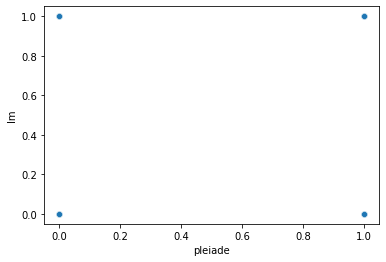

In [131]:
sns.scatterplot(x='pleiade', y="lm", data=df_canon_spec)

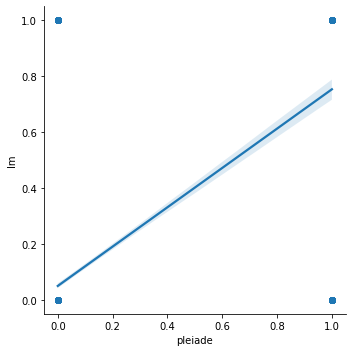

In [133]:
sns.lmplot(data=df_canon_spec, x="pleiade", y="lm")

<AxesSubplot:xlabel='pleiade', ylabel='lm'>

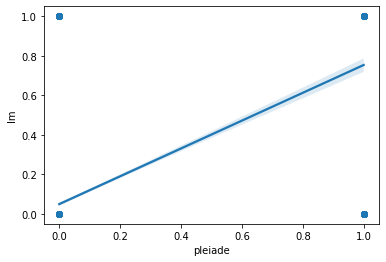

In [134]:
sns.regplot(data=df_canon_spec, x="pleiade", y="lm")

In [135]:
np.corrcoef(df_canon_spec['pleiade'], df_canon_spec['lm'])

array([[1.        , 0.71634589],
       [0.71634589, 1.        ]])

In [136]:
pearsonr(df_canon_spec['pleiade'], df_canon_spec['lm'])

(0.7163458882624895, 0.0)

<AxesSubplot:xlabel='bac', ylabel='sup'>

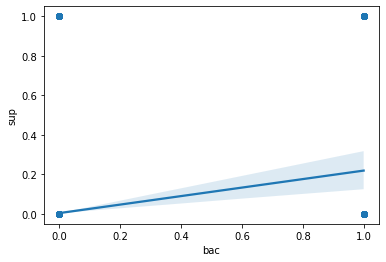

In [137]:
sns.regplot(data=df_canon_spec, x="bac", y="sup")

In [102]:
np.corrcoef(df_canon_spec['gf'], df_canon_spec['gouv'])

array([[1.        , 0.25882998],
       [0.25882998, 1.        ]])